# Sinusoidal with timechanging parameters
This notebook extends `sinus.ipynb` to demo the results of when the parameters governing the process change values durin the course of the timeseries. We import the necessary objects and define the model

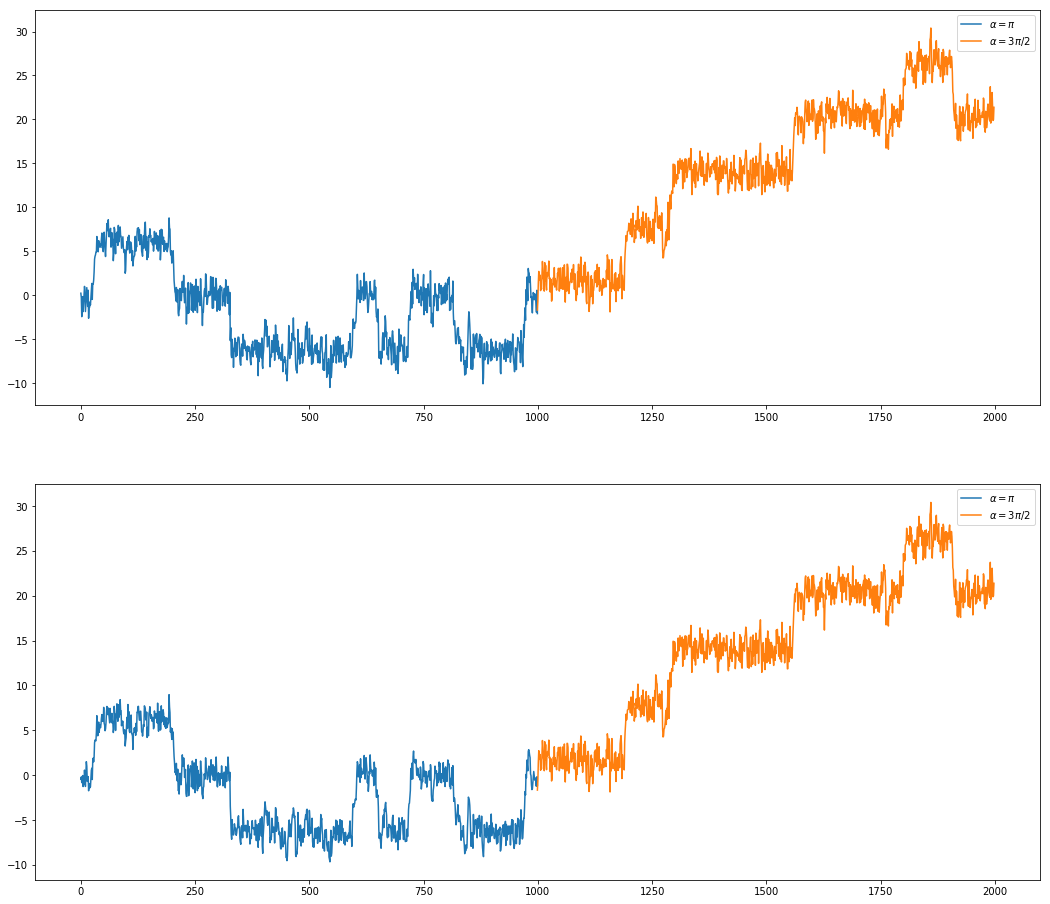

In [5]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable
import numpy as np
import matplotlib.pyplot as plt
from pyfilter.distributions.continuous import Normal


def fh0(alpha, sigma):
    return 0


def gh0(alpha, sigma):
    return sigma


def fh(x, alpha, sigma):
    return np.sin(x - alpha)


def gh(x, alpha, sigma):
    return sigma


def go(x, beta):
    return x


def fo(x, beta):
    return beta

# ===== SIMULATE FIRST PART OF SSM ===== #

sinus = EulerMaruyma((fh0, gh0), (fh, gh), (np.pi, 1), (Normal(), Normal()))
obs = Observable((go, fo), (0.6,), Normal())

simmodel = StateSpaceModel(sinus, obs)

x_first, y_first = simmodel.sample(1000)

saved_first_params = simmodel.hidden.theta[:]
simmodel.hidden.theta = (np.pi * 3 / 2, 1)

x_second, y_second = simmodel.sample(1000, x_s=x_first[-1])

first_index = range(len(y_first))
second_index = range(len(y_first)-1, len(y_first)-1 + len(y_second))

fig, ax = plt.subplots(2, figsize=(18, 16))
ax[0].plot(first_index, y_first, label='$\\alpha = \\pi$')
ax[1].plot(first_index, x_first, label='$\\alpha = \\pi$')

ax[0].plot(second_index, y_second, label='$\\alpha = 3\\pi/2$')
ax[1].plot(second_index, y_second, label='$\\alpha = 3\\pi/2$')

ax[0].legend()
ax[1].legend()

We use similar priors as in `sinus.ipynb` and thus get

In [2]:
from pyfilter.distributions.continuous import Gamma


sinus = EulerMaruyma((fh0, gh0), (fh, gh), (Gamma(4), Gamma(4)), (Normal(), Normal()))
obs = Observable((go, fo), (Gamma(4),), Normal())

ssm = StateSpaceModel(sinus, obs)

We use the exact same inference algorithms, and thus get (saving the posteriors for the first half).

In [3]:
from pyfilter.filters import NESS, UKF

alg = NESS(ssm, (1500,), filt=UKF).initialize().longfilter(y_first)

first_posteriors = [*alg.ssm.observable.theta[:], *alg.ssm.hidden.theta[:]]
first_params = [*simmodel.observable.theta[:], *saved_first_params]

alg = alg.longfilter(y_second[1:])

second_posteriors = [*alg.ssm.observable.theta[:], *alg.ssm.hidden.theta[:]]
second_params = [*simmodel.observable.theta[:], *simmodel.hidden.theta[:]]

Let's plot them as usual

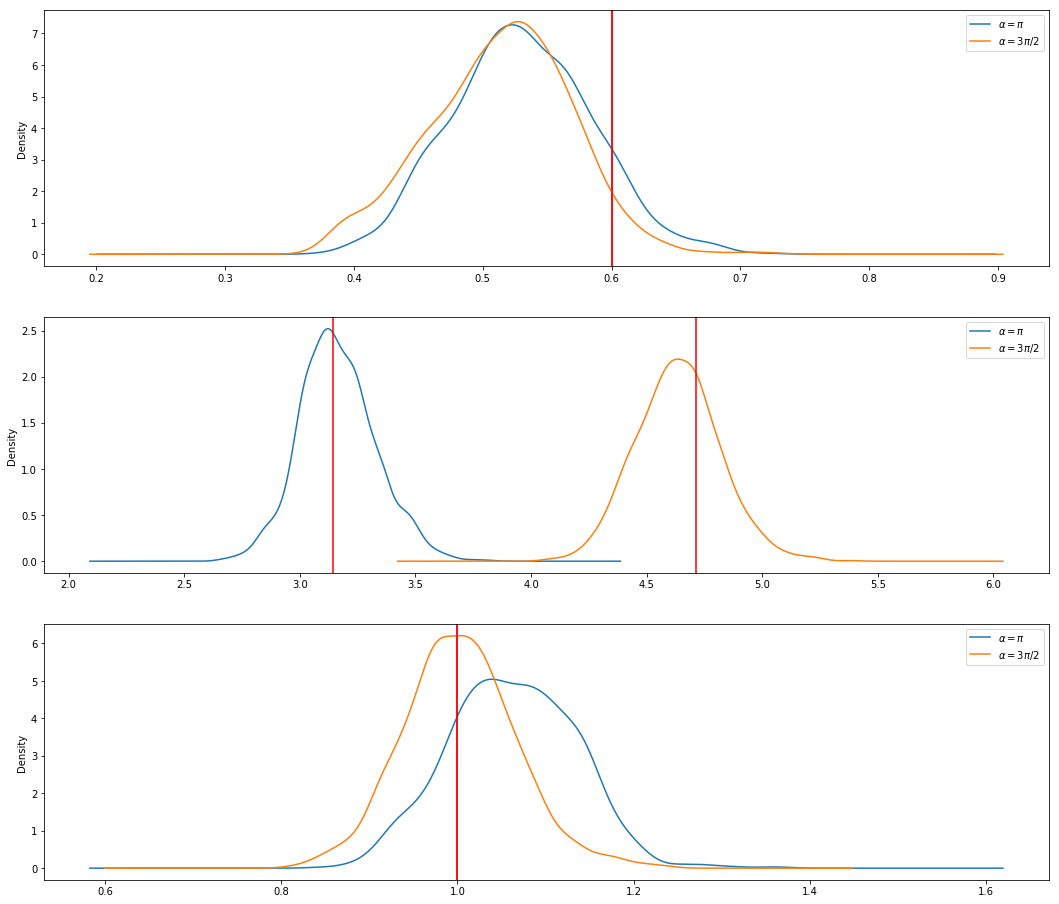

In [4]:
import pandas as pd


fig, ax = plt.subplots(len(first_posteriors), figsize=(18, 16))
labels = ('$\\alpha = \\pi$', '$\\alpha = 3\\pi/2$')


for l, (posts, tparams) in zip(labels, ((first_posteriors, first_params), (second_posteriors, second_params))):
    for i, (p, tp) in enumerate(zip(posts, tparams)):
        pd.DataFrame(p, columns=[l]).plot(kind='kde', ax=ax[i])
        ax[i].axvline(tp, color='r')
        
plt.show()